## Import Needed Libraries

In [2]:
import os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report 
import joblib
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Read Data

In [3]:
data_dir='/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer'
target_folder='Brain Cancer'
filepath=[]
labels=[]
all_folder_path = os.path.join(data_dir, target_folder)

if os.path.isdir(all_folder_path):
    filelist = os.listdir(all_folder_path)
    for f in filelist:
        fpath = os.path.join(all_folder_path, f)
        fipath=os.listdir(fpath)
        for image in fipath:
            path = os.path.join(fpath, image)
            filepath.append(path)
            labels.append(f)  

f_series = pd.Series(filepath, name='filepath')
l_series = pd.Series(labels, name='labels')
df = pd.concat([f_series, l_series], axis=1)

In [4]:
count=df['labels'].value_counts().reset_index()
count.columns=['labels','count']
count_fig=px.bar(count,x='labels',y='count',title='count of labels',text_auto=True)
count_fig.show()

## split Data

In [6]:
strat=df['labels']
train_df ,dummy_df=train_test_split(df,test_size=0.3,random_state=42,stratify=strat)
strate=dummy_df['labels']
valid_df,test_df=train_test_split(dummy_df,test_size=0.5,random_state=42,stratify=strate)

# Saving test images for model testing after finishing

In [30]:
import os
import shutil
import random
import pandas as pd


output_dir = "/kaggle/working/test_images_10"
os.makedirs(output_dir, exist_ok=True)

# Group test_df by labels
grouped = test_df.groupby('labels')

for label, group_df in grouped:
    output_label_dir = os.path.join(output_dir, label)
    os.makedirs(output_label_dir, exist_ok=True)

    file_paths = group_df['filepath'].tolist()

    if len(file_paths) >= 10:
        selected_files = random.sample(file_paths, 10)
    else:
        selected_files = file_paths

    for file_path in selected_files:
        file_name = os.path.basename(file_path)
        destination_path = os.path.join(output_label_dir, file_name)
        shutil.copyfile(file_path, destination_path)

print(f"Downloaded 10 images (or all available) from each label in test_df to: {output_dir}")

Downloaded 10 images (or all available) from each label in test_df to: /kaggle/working/test_images_10


In [7]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(10500, 2)
(2250, 2)
(2250, 2)


In [8]:
count_train=train_df['labels'].value_counts().reset_index()
count_train.columns=['labels','count']
count=px.bar(count_train,x='labels',y='count',title='count of labels per train_df',text_auto=True)
count.show()

In [9]:
count

In [9]:
count_valid=valid_df['labels'].value_counts().reset_index()
count_valid.columns=['labels','count']
fig=px.bar(count_valid,x='labels',y='count',title='count of labels per valid_df',text_auto=True)
fig.show()

In [10]:
count_test=test_df['labels'].value_counts().reset_index()
count_test.columns=['labels','count']
fig=px.bar(count_test,x='labels',y='count',title='count of labels per test_df',text_auto=True)
fig.show()

## Data Augmentation

In [11]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator(
    rotation_range=40,        
    width_shift_range=0.2,    
    height_shift_range=0.2,   
    horizontal_flip=True,     
    fill_mode='nearest' )      
ts_gen=ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 10500 validated image filenames belonging to 3 classes.
Found 2250 validated image filenames belonging to 3 classes.
Found 2250 validated image filenames belonging to 3 classes.


## sample of Data

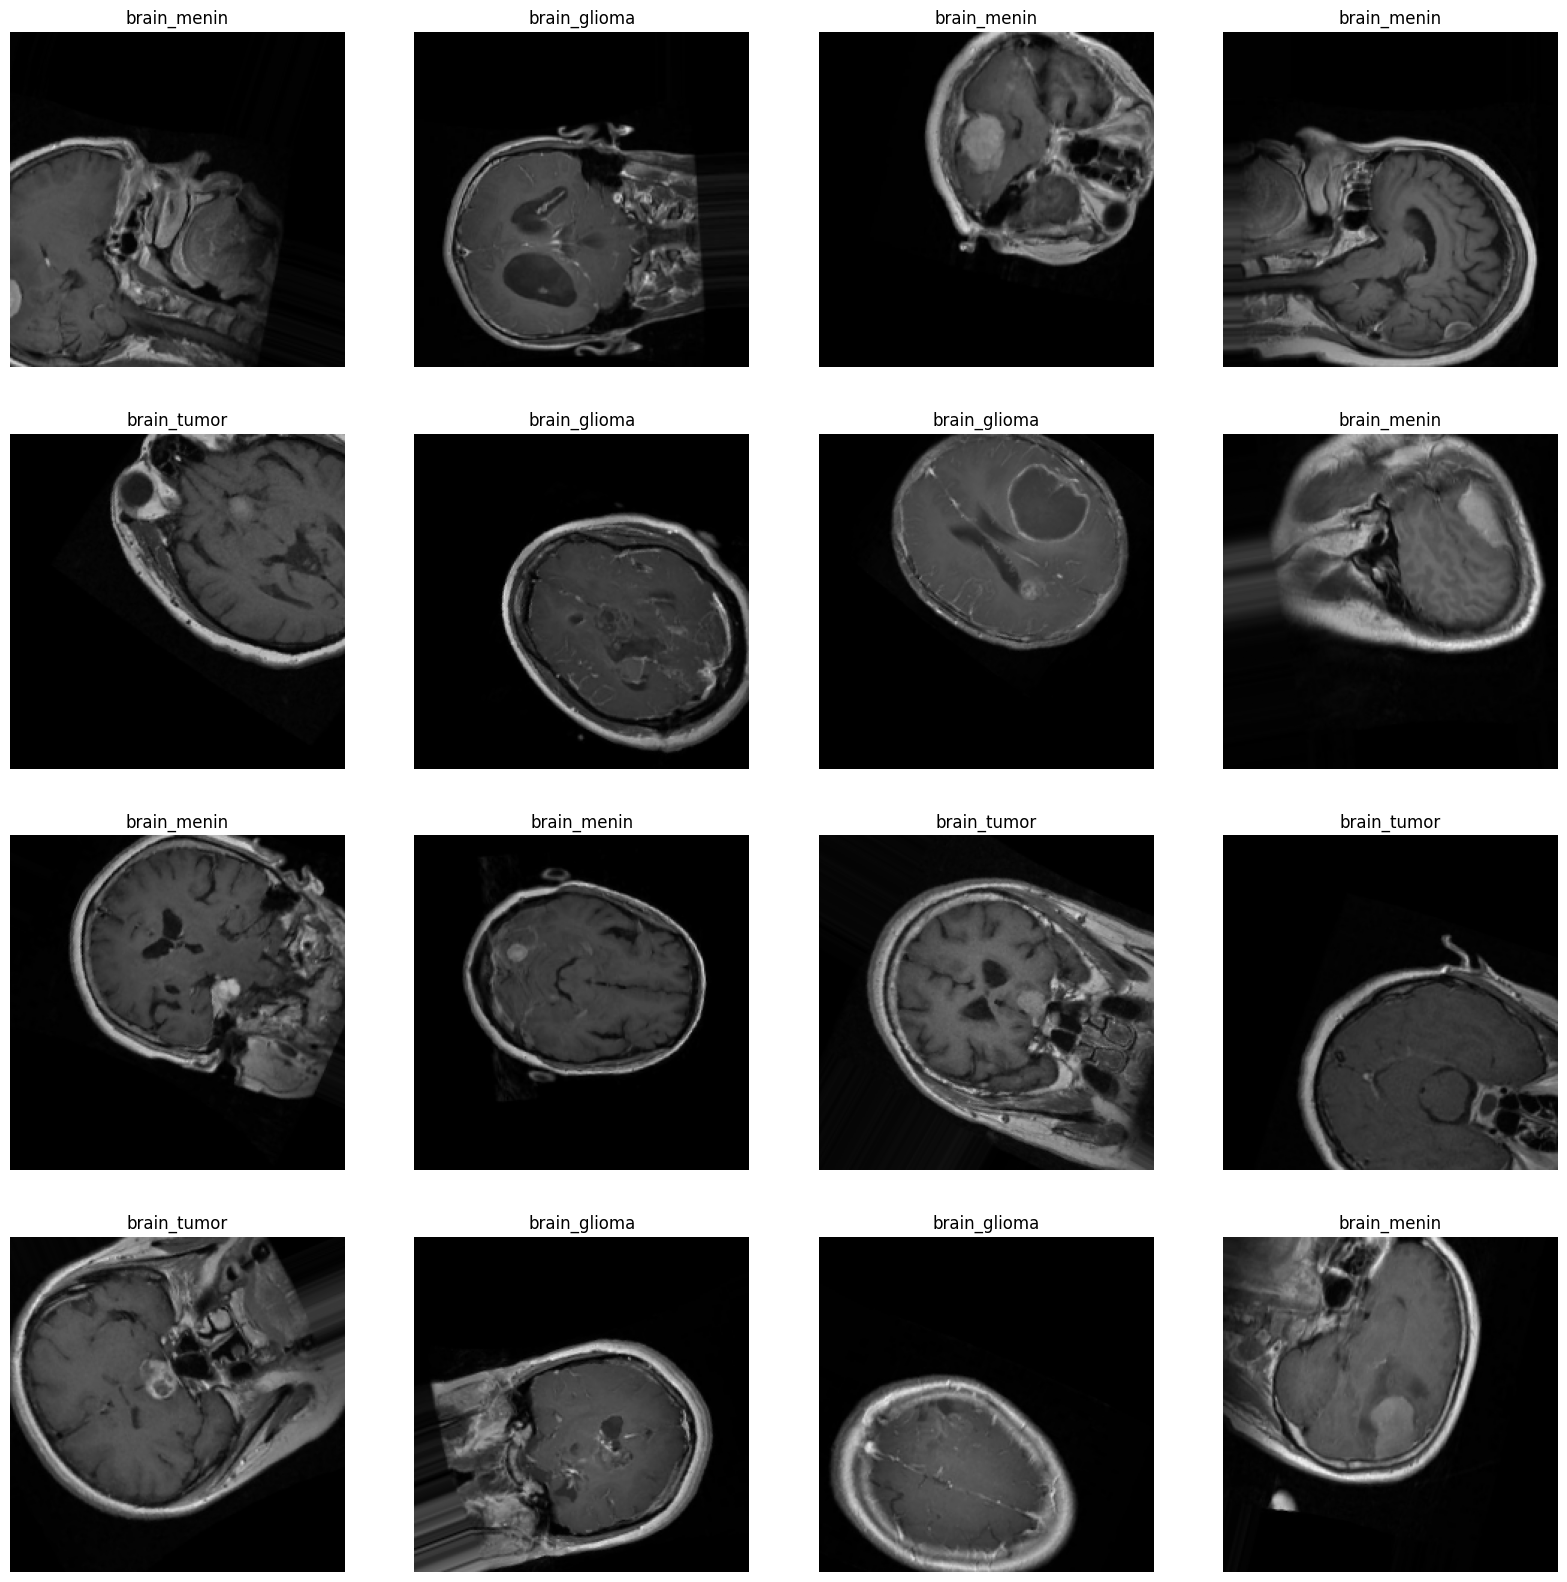

In [13]:
g_dict = train_gen.class_indices    
classes = list(g_dict.keys())      
images, labels = next(train_gen)     
plt.figure(figsize= (20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255      
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'black', fontsize= 12)
    plt.axis('off')
plt.show()

## Bulid model

In [15]:
base_model=keras.applications.EfficientNetB0(include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))
model=Sequential([
    base_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.25),
    Dense(128,activation='relu'),
    Dense(3,activation='softmax')
])
model.compile(Adamax(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

Exception: URL fetch failure on https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5: None -- [Errno -3] Temporary failure in name resolution

In [ ]:
model.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
history=model.fit(train_gen,epochs=100,validation_data=valid_gen,shuffle=False,
                  callbacks=[early_stopping])

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## Evalution

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

## Confusion Matrix

In [ ]:
plt.figure(figsize=(10,5))
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);

## classification Report

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

## save model

In [ ]:
model.save('Brain tumor classification_edit.h5')